## Custom images - basic steps

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # Add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

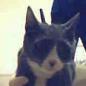

In [4]:
## CHECK FILE PATH
with Image.open("Data/CATS_DOGS/test/CAT/10107.jpg") as im:
    display(im)

In [5]:
path = "Data/CATS_DOGS/"
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+"/"+img)

In [6]:
#img_names

In [7]:
len(img_names)

24996

## Filter out non images

In [8]:
img_sizes = []
rejected = []
for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [9]:
print(len(img_sizes))
print(len(rejected))

24994
2


In [10]:
df = pd.DataFrame(img_sizes)

In [11]:
df.head()

,0,1
0,365,500
1,484,500
2,448,500
3,500,483
4,500,375


## Check statistics of img height and width
e.g. 25% of the samples has a height of 323

In [12]:
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [13]:
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

In [14]:
dog = Image.open("Data/CATS_DOGS/train/DOG/14.jpg")

display(dog)

In [15]:
dog.size

(500, 387)

In [16]:
## Transform to tensor

In [17]:
# Compose låter oss göra flera operationer
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)

In [18]:
type(im)

torch.Tensor

- Im is transformed to a value between 0 and 1

In [19]:
im[:,0,0]

tensor([0.3529, 0.3725, 0.3843])

In [20]:
dog.getpixel((0,0))

(90, 95, 98)

In [21]:
np.array(dog.getpixel((0,0)))/255

array([0.35294118, 0.37254902, 0.38431373])

## Transform back in order to plot
To be able to plot. Imshow expec the form [387,500,3]

In [22]:
im.shape
# Must be in the form 387,500,3

torch.Size([3, 387, 500])

In [23]:
np.transpose(im.numpy(), (1,2,0)).shape

(387, 500, 3)

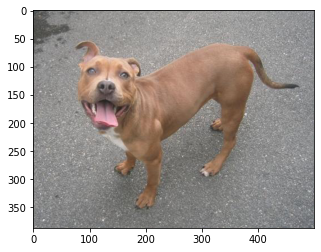

In [24]:
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## Resize and change an image

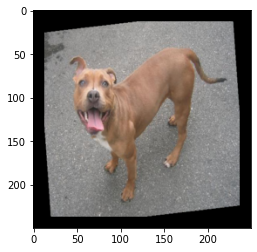

In [25]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.CenterCrop(250), # Crop
    transforms.ToTensor()
])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

# Build dataset

In [55]:
train_transform = transforms.Compose([
    #transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize([0.485,0.456,0.406],
    #                    [0.229,0.224,0.225])
])

In [27]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])
])

In [28]:
root = "Data/CATS_DOGS/"

In [56]:
train_data = datasets.ImageFolder(os.path.join(root,"train"), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,"test"), transform=test_transform)

torch.manual_seed(42)
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes

In [57]:
len(train_data)

18743

In [44]:
len(test_data)

6251

In [45]:
for images, labels in train_loader:
    break

In [46]:
images.shape

torch.Size([10, 3, 224, 224])

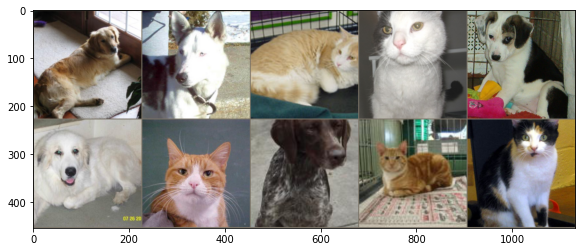

In [47]:
im = make_grid(images, nrow=5)

# inverse normalize

inv_normalize = transforms.Normalize(
mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))
plt.show()

## Create model

In [48]:
class Convolutionalnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1) # 3:input channel (3 colors),6: output Channels (filters) (arbitrary),5: Kernel. ,1: Stide
        self.conv2 = nn.Conv2d(6,16 ,3,1) # 16 and 3 is arbitrary and can be modified for better training performance
        self.fc1 = nn.Linear(54*54*16,120) # Se pytorch lect 71 ca 15 min hur denna räknas ut
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = self.conv1(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = self.conv2(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)
        

In [49]:
torch.manual_seed(101)
model = Convolutionalnetwork()
model

Convolutionalnetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [58]:
##### DET VERKAR VARA NÅGOT FEL PÅ DENNA: if b >= max_trn_batch: tycks inte funka som den skall

In [51]:
import time
start_time = time.time()

# Variables (trackers)
epochs = 3

# Limits
max_trn_batch = 300 #800 batch 10 images ---> 8000 images
max_tst_batch = 100 # 300
 

train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0 

    # Train 
    for b, (X_train, y_train) in enumerate(train_loader):
        
        if b >= max_trn_batch:
            break
        
        b+=1
        
        y_pred = model(X_train) # NOTE. No need to flatten as conv2d expect 2d data
        lossTrain = criterion(y_pred, y_train)
        #lossTrain = criterion(y_pred, y_train).data

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 / False 0 
        trn_corr += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        if b%6 == 0:
            print(f"EPOCH {i:2} BATCH: {b:4} [{10*b:6}/XXXXX] LOSS: {lossTrain.item()} accuracy: {trn_corr.item()*100/(10*b):7.3}%")
    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_corr)

    # Test (If we feed in test data during traing, how well will it perform)
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            
            if b >= max_tst_batch:
                break
            
            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

current_time = time.time() 
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH  0 BATCH:    6 [    60/XXXXX] LOSS: 0.7110207676887512 accuracy:    53.3%
EPOCH  0 BATCH:   12 [   120/XXXXX] LOSS: 0.6403033137321472 accuracy:    55.8%
EPOCH  0 BATCH:   18 [   180/XXXXX] LOSS: 0.7214341759681702 accuracy:    52.2%
EPOCH  0 BATCH:   24 [   240/XXXXX] LOSS: 0.8418238759040833 accuracy:    51.7%
EPOCH  0 BATCH:   30 [   300/XXXXX] LOSS: 0.6601552367210388 accuracy:    53.3%
EPOCH  0 BATCH:   36 [   360/XXXXX] LOSS: 0.6880372166633606 accuracy:    53.6%
EPOCH  0 BATCH:   42 [   420/XXXXX] LOSS: 0.7095637917518616 accuracy:    52.6%
EPOCH  0 BATCH:   48 [   480/XXXXX] LOSS: 0.6866881847381592 accuracy:    51.9%
EPOCH  0 BATCH:   54 [   540/XXXXX] LOSS: 0.710469126701355 accuracy:    51.5%
EPOCH  0 BATCH:   60 [   600/XXXXX] LOSS: 0.678179919719696 accuracy:    52.0%
EPOCH  0 BATCH:   66 [   660/XXXXX] LOSS: 0.6761959791183472 accuracy:    51.4%
EPOCH  0 BATCH:   72 [   720/XXXXX] LOSS: 0.6853281259536743 accuracy:    51.9%
EPOCH  0 BATCH:   78 [   780/XXXXX] LOSS: 

EPOCH  2 BATCH:   24 [   240/XXXXX] LOSS: 0.7116098999977112 accuracy:    63.8%
EPOCH  2 BATCH:   30 [   300/XXXXX] LOSS: 0.389233261346817 accuracy:    64.7%
EPOCH  2 BATCH:   36 [   360/XXXXX] LOSS: 0.6759127974510193 accuracy:    63.6%
EPOCH  2 BATCH:   42 [   420/XXXXX] LOSS: 0.6081054210662842 accuracy:    66.0%
EPOCH  2 BATCH:   48 [   480/XXXXX] LOSS: 0.607241690158844 accuracy:    64.6%
EPOCH  2 BATCH:   54 [   540/XXXXX] LOSS: 0.6400282382965088 accuracy:    65.0%
EPOCH  2 BATCH:   60 [   600/XXXXX] LOSS: 0.6288930773735046 accuracy:    65.5%
EPOCH  2 BATCH:   66 [   660/XXXXX] LOSS: 0.38602977991104126 accuracy:    65.3%
EPOCH  2 BATCH:   72 [   720/XXXXX] LOSS: 0.4175547957420349 accuracy:    65.7%
EPOCH  2 BATCH:   78 [   780/XXXXX] LOSS: 0.5780028700828552 accuracy:    66.2%
EPOCH  2 BATCH:   84 [   840/XXXXX] LOSS: 0.5569117069244385 accuracy:    66.3%
EPOCH  2 BATCH:   90 [   900/XXXXX] LOSS: 0.39933618903160095 accuracy:    66.2%
EPOCH  2 BATCH:   96 [   960/XXXXX] LOSS

## Evaluate performance

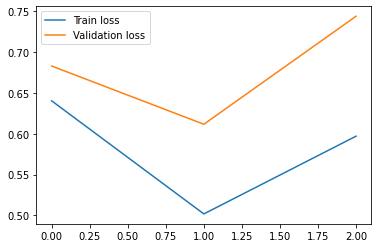

In [52]:
plt.plot(train_losses,label="Train loss")
plt.plot(test_losses, label="Validation loss")
plt.legend()

## Accuracy

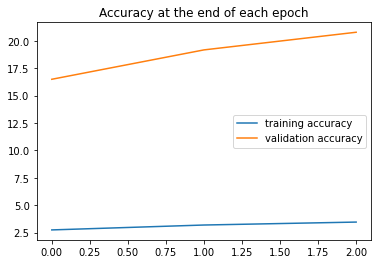

In [53]:
size1 = max_trn_batch/batch_size
size2 = max_tst_batch/batch_size
plt.plot([t/600 for t in train_correct], label="training accuracy")
plt.plot([t/100 for t in train_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()